# Kubeflow Pipelines e2e mnist example

In this notebook you will create e2e mnist Kubeflow Pipeline to perfom:
- Hyperparameter tuning using Katib
- Distributive training with the best hyperparameters using TFJob
- Serve the trained model using KFServing

Reference documentation:

- https://www.kubeflow.org/docs/components/training/tftraining/
- https://www.kubeflow.org/docs/components/katib/
- https://www.kubeflow.org/docs/components/kfserving/

**Note**: This Pipeline runs in the multi-user mode. To run this Pipeline your Notebook should have the appropriate `PodDefault` with `pipelines.kubeflow.org` audience.

Follow these steps before creating this Notebook.

1. Deploy the `PodDefault`:

```yaml
apiVersion: kubeflow.org/v1alpha1
kind: PodDefault
metadata:
  name: access-kf-pipeline
  namespace: kubeflow-user-example-com
spec:
  desc: Allow access to KFP
  selector:
    matchLabels:
      access-kf-pipeline: "true"
  volumeMounts:
    - mountPath: /var/run/secrets/kubeflow/pipelines
      name: volume-kf-pipeline-token
      readOnly: true
  volumes:
    - name: volume-kf-pipeline-token
      projected:
        sources:
          - serviceAccountToken:
              path: token
              expirationSeconds: 7200
              audience: pipelines.kubeflow.org
  env:
    - name: KF_PIPELINES_SA_TOKEN_PATH
      value: /var/run/secrets/kubeflow/pipelines/token

```

2. Select the appropriate configuration to attach above `PodDefault` to the Notebook:

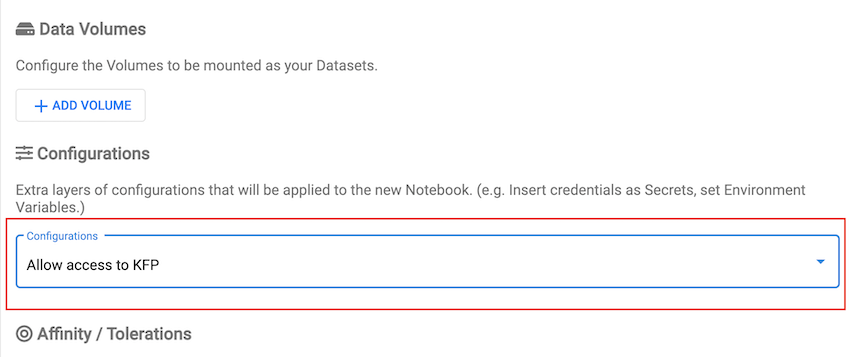

In [ ]:
# Install required packages.
!pip install kfp==1.8.4
!pip install kubeflow-katib==0.12.0

In [ ]:
import kfp
import kfp.dsl as dsl
from kfp import components

from kubeflow.katib import ApiClient
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec

## Define the Pipelines tasks

To run this Pipeline, you should define:
1. Katib hyperparameter tuning
2. TFJob training
3. KFServing inference



### Step 1. Katib hyperparameter tuning task

Create the Kubeflow Pipelines task for the Katib hyperparameter tuning. This Experiment uses "random" algorithm and TFJob for the Trial's worker.

The Katib Experiment is similar to this example: https://github.com/kubeflow/katib/blob/master/examples/v1beta1/tfjob-example.yaml.

In [ ]:
# You should define the Experiment name, namespace and number of training steps in the arguments.
def create_katib_experiment_task(experiment_name, experiment_namespace, training_steps):
    # Trial count specification.
    max_trial_count = 5
    max_failed_trial_count = 3
    parallel_trial_count = 2

    # Objective specification.
    objective = V1beta1ObjectiveSpec(
        type="minimize",
        goal=0.001,
        objective_metric_name="loss"
    )

    # Algorithm specification.
    algorithm = V1beta1AlgorithmSpec(
        algorithm_name="random",
    )

    # Experiment search space.
    # In this example we tune learning rate and batch size.
    parameters = [
        V1beta1ParameterSpec(
            name="learning_rate",
            parameter_type="double",
            feasible_space=V1beta1FeasibleSpace(
                min="0.01",
                max="0.05"
            ),
        ),
        V1beta1ParameterSpec(
            name="batch_size",
            parameter_type="int",
            feasible_space=V1beta1FeasibleSpace(
                min="80",
                max="100"
            ),
        )
    ]

    # Experiment Trial template.
    # TODO (andreyvelich): Use community image for the mnist example.
    trial_spec = {
        "apiVersion": "kubeflow.org/v1",
        "kind": "TFJob",
        "spec": {
            "tfReplicaSpecs": {
                "Chief": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                },
                "Worker": {
                    "replicas": 1,
                    "restartPolicy": "OnFailure",
                    "template": {
                        "metadata": {
                            "annotations": {
                                "sidecar.istio.io/inject": "false"
                            }
                        },
                        "spec": {
                            "containers": [
                                {
                                    "name": "tensorflow",
                                    "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                                    "command": [
                                        "python",
                                        "/opt/model.py",
                                        "--tf-train-steps=" + str(training_steps),
                                        "--tf-learning-rate=${trialParameters.learningRate}",
                                        "--tf-batch-size=${trialParameters.batchSize}"
                                    ]
                                }
                            ]
                        }
                    }
                }
            }
        }
    }

    # Configure parameters for the Trial template.
    trial_template = V1beta1TrialTemplate(
        primary_container_name="tensorflow",
        trial_parameters=[
            V1beta1TrialParameterSpec(
                name="learningRate",
                description="Learning rate for the training model",
                reference="learning_rate"
            ),
            V1beta1TrialParameterSpec(
                name="batchSize",
                description="Batch size for the model",
                reference="batch_size"
            ),
        ],
        trial_spec=trial_spec
    )

    # Create an Experiment from the above parameters.
    experiment_spec = V1beta1ExperimentSpec(
        max_trial_count=max_trial_count,
        max_failed_trial_count=max_failed_trial_count,
        parallel_trial_count=parallel_trial_count,
        objective=objective,
        algorithm=algorithm,
        parameters=parameters,
        trial_template=trial_template
    )

    # Create the KFP task for the Katib Experiment.
    # Experiment Spec should be serialized to a valid Kubernetes object.
    katib_experiment_launcher_op = components.load_component_from_url(
        "https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml")
    op = katib_experiment_launcher_op(
        experiment_name=experiment_name,
        experiment_namespace=experiment_namespace,
        experiment_spec=ApiClient().sanitize_for_serialization(experiment_spec),
        experiment_timeout_minutes=60,
        delete_finished_experiment=False)

    return op

### Step 2. TFJob training task

Create the Kubeflow Pipelines task for the TFJob training. In this example TFJob runs the Chief and Worker with 1 replica.

Learn more about TFJob replica specifications in the Kubeflow docs: https://www.kubeflow.org/docs/components/training/tftraining/#what-is-tfjob.

In [ ]:
# This function converts Katib Experiment HP results to args.
def convert_katib_results(katib_results) -> str:
    import json
    import pprint
    katib_results_json = json.loads(katib_results)
    print("Katib results:")
    pprint.pprint(katib_results_json)
    best_hps = []
    for pa in katib_results_json["currentOptimalTrial"]["parameterAssignments"]:
        if pa["name"] == "learning_rate":
            best_hps.append("--tf-learning-rate=" + pa["value"])
        elif pa["name"] == "batch_size":
            best_hps.append("--tf-batch-size=" + pa["value"])
    print("Best Hyperparameters: {}".format(best_hps))
    return " ".join(best_hps)

In [ ]:
# You should define the TFJob name, namespace, number of training steps, output of Katib and model volume tasks in the arguments.
def create_tfjob_task(tfjob_name, tfjob_namespace, training_steps, katib_op, model_volume_op):
    import json
    # Get parameters from the Katib Experiment.
    # Parameters are in the format "--tf-learning-rate=0.01 --tf-batch-size=100"
    convert_katib_results_op = components.func_to_container_op(convert_katib_results)
    best_hp_op = convert_katib_results_op(katib_op.output)
    best_hps = str(best_hp_op.output)

    # Create the TFJob Chief and Worker specification with the best Hyperparameters.
    # TODO (andreyvelich): Use community image for the mnist example.
    tfjob_chief_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c"
                        ],
                        "args": [
                            "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps={} {}".format(training_steps, best_hps)
                        ],
                        "volumeMounts": [
                            {
                                "mountPath": "/mnt/export",
                                "name": "model-volume"
                            }
                        ]
                    }
                ],
                "volumes": [
                    {
                        "name": "model-volume",
                        "persistentVolumeClaim": {
                            "claimName": str(model_volume_op.outputs["name"])
                        }
                    }
                ]
            }
        }
    }

    tfjob_worker_spec = {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
            "metadata": {
                "annotations": {
                    "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "tensorflow",
                        "image": "docker.io/liuhougangxa/tf-estimator-mnist",
                        "command": [
                            "sh",
                            "-c",
                        ],
                        "args": [
                          "python /opt/model.py --tf-export-dir=/mnt/export --tf-train-steps={} {}".format(training_steps, best_hps) 
                        ],
                    }
                ],
            }
        }
    }

    # Create the KFP task for the TFJob.
    tfjob_launcher_op = components.load_component_from_url(
        "https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/launcher/component.yaml")
    op = tfjob_launcher_op(
        name=tfjob_name,
        namespace=tfjob_namespace,
        chief_spec=json.dumps(tfjob_chief_spec),
        worker_spec=json.dumps(tfjob_worker_spec),
        tfjob_timeout_minutes=60,
        delete_finished_tfjob=False)
    return op

### Step 3. KFServing inference

Create the Kubeflow Pipelines task for the KFServing inference.

In [ ]:
# You should define the model name, namespace, output of the TFJob and model volume tasks in the arguments.
def create_kfserving_task(model_name, model_namespace, tfjob_op, model_volume_op):

    inference_service = '''
apiVersion: "serving.kubeflow.org/v1beta1"
kind: "InferenceService"
metadata:
  name: {}
  namespace: {}
  annotations:
    "sidecar.istio.io/inject": "false"
spec:
  predictor:
    tensorflow:
      storageUri: "pvc://{}/"
'''.format(model_name, model_namespace, str(model_volume_op.outputs["name"]))

    kfserving_launcher_op = components.load_component_from_url(
        'https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/kfserving/component.yaml')
    kfserving_launcher_op(action="create", inferenceservice_yaml=inference_service).after(tfjob_op)

## Run the Kubeflow Pipeline

You should create the Kubeflow Pipeline from the above tasks.

In [ ]:
name="mnist-e2e"
namespace="kubeflow-user-example-com"
training_steps="200"

@dsl.pipeline(
    name="End to End Pipeline",
    description="An end to end mnist example including hyperparameter tuning, train and inference"
)
def mnist_pipeline(name=name, namespace=namespace, training_steps=training_steps):
    # Run the hyperparameter tuning with Katib.
    katib_op = create_katib_experiment_task(name, namespace, training_steps)

    # Create volume to train and serve the model.
    model_volume_op = dsl.VolumeOp(
        name="model-volume",
        resource_name="model-volume",
        size="1Gi",
        modes=dsl.VOLUME_MODE_RWO
    )

    # Run the distributive training with TFJob.
    tfjob_op = create_tfjob_task(name, namespace, training_steps, katib_op, model_volume_op)

    # Create the KFServing inference.
    create_kfserving_task(name, namespace, tfjob_op, model_volume_op)

# Run the Kubeflow Pipeline in the user's namespace.
kfp_client=kfp.Client()
run_id = kfp_client.create_run_from_pipeline_func(mnist_pipeline, namespace=namespace, arguments={}).run_id
print("Run ID: ", run_id)

The finished Pipeline should look as follows.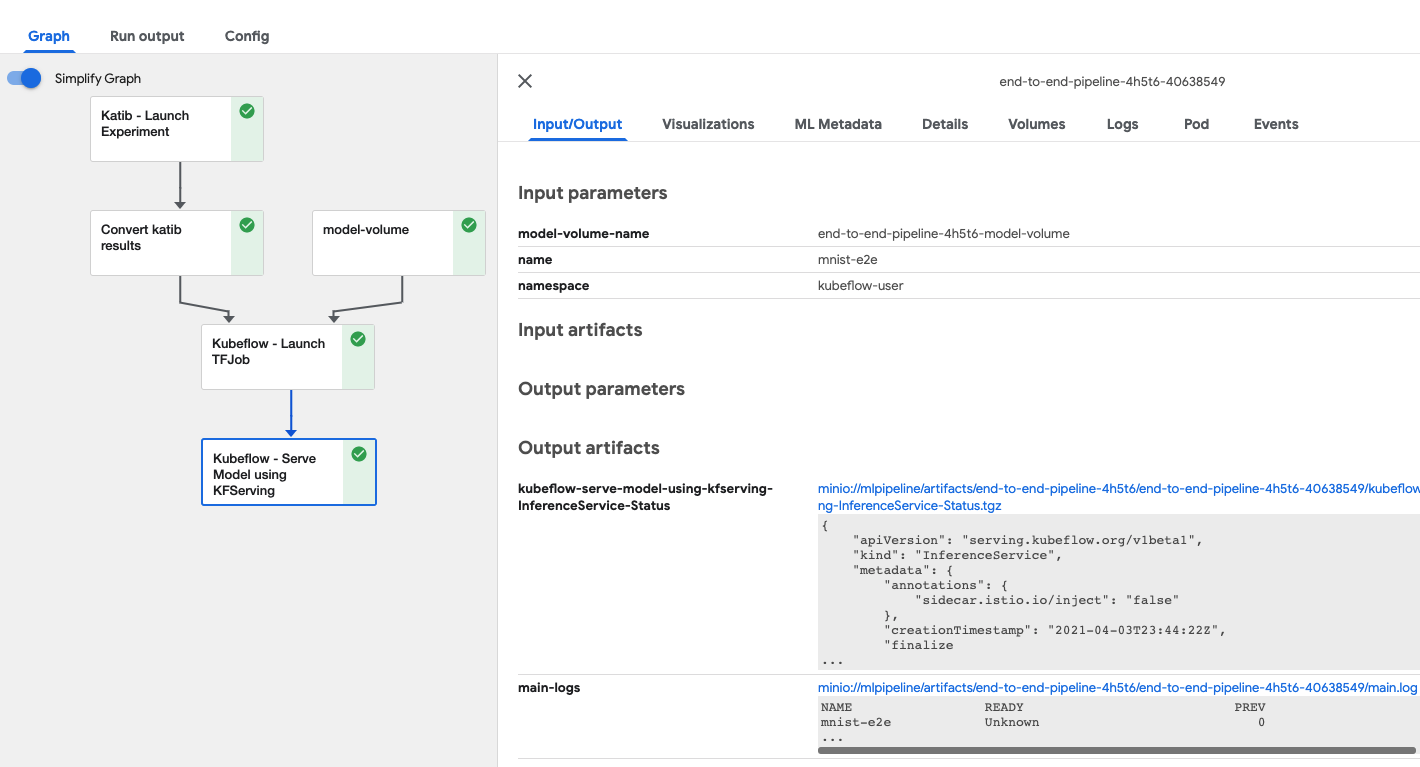

## Predict from the trained model

Once Kubeflow Pipeline is finished, you are able to call the API endpoint to predict from the trained model.
Upload a mnist picture to your notebook, such as `9.bmp` from [here](https://github.com/andreyvelich/pipelines/blob/fix-e2e-mnist-example/samples/contrib/kubeflow-e2e-mnist/9.bmp).

**Note**: If you are using Kubeflow + Dex setup and runing this Notebook outside of your Kubernetes cluster, follow [this guide](https://github.com/kubeflow/kfserving/tree/master/docs/samples/istio-dex#authentication) to get Session ID for the API requests.

In [ ]:
import numpy as np
from PIL import Image
import requests

# Pipeline Run should be succeeded.
kfp_run = kfp_client.get_run(run_id=run_id)
if kfp_run.run.status == "Succeeded":
    print("Run {} has been Succeeded\n".format(run_id))

    # Specify the image path here.
    image = Image.open("9.bmp")
    data = np.array(image.convert('L').resize((28, 28))).astype(np.float).reshape(-1, 28, 28, 1)
    data_formatted = np.array2string(data, separator=",", formatter={"float": lambda x: "%.1f" % x})
    json_request = '{{ "instances" : {} }}'.format(data_formatted)

    # Specify the prediction URL. If you are runing this notebook outside of Kubernetes cluster, you should set the Cluster IP.
    url = "http://{}-predictor-default.{}.svc.cluster.local/v1/models/{}:predict".format(name, namespace, name)
    response = requests.post(url, data=json_request)

    print("Prediction for the image")
    display(image)
    print(response.json())
